# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/alessandrobertelli/Desktop/University/KTH/mlfs-book
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 9, 50, 38, 666233)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
data = json.loads(location_str)

country=data['country']
city=data['city']
latitude=data['latitude']
longitude=data['longitude']
sensors = data['sensors']
street = sensors[0]['street']
print(sensors)

2025-11-18 09:50:38,670 INFO: Initializing external client
2025-11-18 09:50:38,671 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 09:50:40,419 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 09:50:43,626 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1299605
[{'uid': 9352, 'country': 'italy', 'city': 'rome', 'street': 'Arenula', 'url': 'https://api.waqi.info/feed/@9352'}, {'uid': 9344, 'country': 'italy', 'city': 'rome', 'street': 'Guidonia', 'url': 'https://api.waqi.info/feed/@9344'}, {'uid': 9348, 'country': 'italy', 'city': 'rome', 'street': 'Cipro', 'url': 'https://api.waqi.info/feed/@9348'}, {'uid': 9345, 'country': 'italy', 'city': 'rome', 'street': 'Villa ada', 'url': 'https://api.waqi.info/feed/@9345'}, {'uid': 9346, 'country': 'italy', 'city': 'rome', 'street': 'Guido', 'url': 'https://api.waqi.info/feed/@9346'}, {'uid': 9347, 'country': 'italy', 'city': 'rome', 'street': 'Cavaliere', 'url': 'https://api.waqi.info/feed/@9347'}, {'uid': 9349, 'country': 'italy', 'city': 'rome', 'street': 'Malagrotta', 'url': 'https://api.waqi.info/feed/@9349'}, {'uid': 9342, 'country': 'italy', 'city': 'rome', 'st

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

models = mr.get_models("air_quality_xgboost_model")
latest_model_v = max([m.version for m in models])
print("Latest version of the models:" ,latest_model_v)

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=latest_model_v,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Latest version of the models: 9
2025-11-18 09:51:01,007 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/620228 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/102338 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26567 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='5.008364E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=2,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.96s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,relative_humidity_2m_mean,surface_pressure_mean,city
0,2025-11-20 00:00:00+00:00,13.60,0.7,7.280550,188.530685,92.0,1005.481018,rome
1,2025-11-21 00:00:00+00:00,10.90,1.5,13.551500,343.009094,89.0,1000.862732,rome
2,2025-11-19 00:00:00+00:00,15.55,0.0,0.509117,135.000107,67.0,1006.701477,rome
3,2025-11-22 00:00:00+00:00,10.60,0.0,0.804985,153.435013,68.0,1003.548706,rome
4,2025-11-23 00:00:00+00:00,12.50,0.1,11.901798,176.531845,70.0,1007.359741,rome


In [8]:
# Retrieve recent PM2.5 entries for constructing lag variables
aq_fg = fs.get_feature_group(name='air_quality', version=1)

forecast_list = []  # for all the sensors

# Pull PM2.5 data from the past 3 days for all sensors
for s in sensors:
    three_day_from_today = today - datetime.timedelta(days=3)
    print("three day from today: ", three_day_from_today)
    pm25_window = aq_fg.filter(
        (aq_fg.date >= three_day_from_today) & 
        (aq_fg.street == s['street'])
        ).read()
    pm25_window = pm25_window.sort_values('date')

    print("Recent PM2.5 measurements (3-day window):")
    print(pm25_window[['date', 'pm25']])

    # Prepare lagged PM2.5 values
    pm_series = pm25_window['pm25'].values
    n_vals = len(pm_series)

    # Use match-case to select how to compute the lag features
    match n_vals:
        case n if n >= 3:
            pm25_lagged1 = pm_series[-1]
            pm25_lagged2 = pm_series[-2]
            pm25_lagged3 = pm_series[-3]
        case 2:
            pm25_lagged1 = pm_series[-1]
            pm25_lagged2 = pm_series[-2]
            pm25_lagged3 = pm_series[-2]
        case 1:
            pm25_lagged1 = pm_series[-1]
            pm25_lagged2 = pm_series[-1]
            pm25_lagged3 = pm_series[-1]
        case _:
            pm25_lagged1 = pm25_lagged2 = pm25_lagged3 = 30.0
            print("Note: No recent PM2.5 records found, using fallback value 30.0")

    print("\nComputed lag variables:")
    print(f"  pm25_lagged1 (yesterday): {pm25_lagged1}")
    print(f"  pm25_lagged2 (2 days ago): {pm25_lagged2}")
    print(f"  pm25_lagged3 (3 days ago): {pm25_lagged3}")

    # Forecasting for the selected sensor
    sensor_forecast = batch_data.copy()
    sensor_forecast['pm25_lagged1'] = pm25_lagged1
    sensor_forecast['pm25_lagged2'] = pm25_lagged2
    sensor_forecast['pm25_lagged3'] = pm25_lagged3
    sensor_forecast['street'] = s['street']
    sensor_forecast['country'] = s['country']
    sensor_forecast['days_before_forecast_day'] = range(1, len(sensor_forecast)+1)
    
    forecast_list.append(sensor_forecast)

batch_data = pd.concat(forecast_list, ignore_index=True)
print(batch_data)
# # Attach lag values to batch_data
# batch_data['pm25_lagged1'] = pm25_lagged1
# batch_data['pm25_lagged2'] = pm25_lagged2
# batch_data['pm25_lagged3'] = pm25_lagged3

three day from today:  2025-11-15 09:50:38.666233
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.94s) 
Recent PM2.5 measurements (3-day window):
                       date  pm25
0 2025-11-17 00:00:00+00:00  55.0
1 2025-11-18 00:00:00+00:00  55.0

Computed lag variables:
  pm25_lagged1 (yesterday): 55.0
  pm25_lagged2 (2 days ago): 55.0
  pm25_lagged3 (3 days ago): 55.0
three day from today:  2025-11-15 09:50:38.666233
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.96s) 
Recent PM2.5 measurements (3-day window):
                       date  pm25
0 2025-11-17 00:00:00+00:00  55.0
1 2025-11-18 00:00:00+00:00  55.0

Computed lag variables:
  pm25_lagged1 (yesterday): 55.0
  pm25_lagged2 (2 days ago): 55.0
  pm25_lagged3 (3 days ago): 55.0
three day from today:  2025-11-15 09:50:38.666233
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.95s) 
Recent PM2.5 measurements (3-day window):
          

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [9]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant',
                'relative_humidity_2m_mean','surface_pressure_mean','pm25_lagged1','pm25_lagged2', 'pm25_lagged3']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,relative_humidity_2m_mean,surface_pressure_mean,city,pm25_lagged1,pm25_lagged2,pm25_lagged3,street,country,days_before_forecast_day,predicted_pm25
0,2025-11-20 00:00:00+00:00,13.60,0.7,7.280550,188.530685,92.0,1005.481018,rome,55.0,55.0,55.0,Arenula,italy,1,56.335941
1,2025-11-21 00:00:00+00:00,10.90,1.5,13.551500,343.009094,89.0,1000.862732,rome,55.0,55.0,55.0,Arenula,italy,2,51.252289
2,2025-11-19 00:00:00+00:00,15.55,0.0,0.509117,135.000107,67.0,1006.701477,rome,55.0,55.0,55.0,Arenula,italy,3,56.960499
3,2025-11-22 00:00:00+00:00,10.60,0.0,0.804985,153.435013,68.0,1003.548706,rome,55.0,55.0,55.0,Arenula,italy,4,59.064526
4,2025-11-23 00:00:00+00:00,12.50,0.1,11.901798,176.531845,70.0,1007.359741,rome,55.0,55.0,55.0,Arenula,italy,5,52.387634
5,2025-11-20 00:00:00+00:00,13.60,0.7,7.280550,188.530685,92.0,1005.481018,rome,55.0,55.0,55.0,Guidonia,italy,1,56.335941
6,2025-11-21 00:00:00+00:00,10.90,1.5,13.551500,343.009094,89.0,1000.862732,rome,55.0,55.0,55.0,Guidonia,italy,2,51.252289
7,2025-11-19 00:00:00+00:00,15.55,0.0,0.509117,135.000107,67.0,1006.701477,rome,55.0,55.0,55.0,Guidonia,italy,3,56.960499
8,2025-11-22 00:00:00+00:00,10.60,0.0,0.804985,153.435013,68.0,1003.548706,rome,55.0,55.0,55.0,Guidonia,italy,4,59.064526
9,2025-11-23 00:00:00+00:00,12.50,0.1,11.901798,176.531845,70.0,1007.359741,rome,55.0,55.0,55.0,Guidonia,italy,5,52.387634


In [10]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         45 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          45 non-null     float32                
 2   precipitation_sum            45 non-null     float32                
 3   wind_speed_10m_max           45 non-null     float32                
 4   wind_direction_10m_dominant  45 non-null     float32                
 5   relative_humidity_2m_mean    45 non-null     float32                
 6   surface_pressure_mean        45 non-null     float32                
 7   city                         45 non-null     object                 
 8   pm25_lagged1                 45 non-null     float32                
 9   pm25_lagged2                 45 non-null     float32                
 10  pm25

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [11]:
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data = batch_data.sort_values(by=['date', 'street'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,relative_humidity_2m_mean,surface_pressure_mean,city,pm25_lagged1,pm25_lagged2,pm25_lagged3,street,country,days_before_forecast_day,predicted_pm25
2,2025-11-19 00:00:00+00:00,15.55,0.0,0.509117,135.000107,67.0,1006.701477,rome,55.0,55.0,55.0,Arenula,italy,3,56.960499
27,2025-11-19 00:00:00+00:00,15.55,0.0,0.509117,135.000107,67.0,1006.701477,rome,63.0,63.0,63.0,Cavaliere,italy,3,68.899986
42,2025-11-19 00:00:00+00:00,15.55,0.0,0.509117,135.000107,67.0,1006.701477,rome,61.0,61.0,61.0,Cinecitta',italy,3,65.589439
12,2025-11-19 00:00:00+00:00,15.55,0.0,0.509117,135.000107,67.0,1006.701477,rome,59.0,59.0,59.0,Cipro,italy,3,61.037567
37,2025-11-19 00:00:00+00:00,15.55,0.0,0.509117,135.000107,67.0,1006.701477,rome,61.0,61.0,61.0,Francia,italy,3,65.589439
22,2025-11-19 00:00:00+00:00,15.55,0.0,0.509117,135.000107,67.0,1006.701477,rome,42.0,42.0,42.0,Guido,italy,3,42.899963
7,2025-11-19 00:00:00+00:00,15.55,0.0,0.509117,135.000107,67.0,1006.701477,rome,55.0,55.0,55.0,Guidonia,italy,3,56.960499
32,2025-11-19 00:00:00+00:00,15.55,0.0,0.509117,135.000107,67.0,1006.701477,rome,50.0,50.0,50.0,Malagrotta,italy,3,51.293209
17,2025-11-19 00:00:00+00:00,15.55,0.0,0.509117,135.000107,67.0,1006.701477,rome,57.0,57.0,57.0,Villa ada,italy,3,66.178360
0,2025-11-20 00:00:00+00:00,13.60,0.7,7.280550,188.530685,92.0,1005.481018,rome,55.0,55.0,55.0,Arenula,italy,1,56.335941


In [12]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, 2 to 19
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         45 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          45 non-null     float32                
 2   precipitation_sum            45 non-null     float32                
 3   wind_speed_10m_max           45 non-null     float32                
 4   wind_direction_10m_dominant  45 non-null     float32                
 5   relative_humidity_2m_mean    45 non-null     float32                
 6   surface_pressure_mean        45 non-null     float32                
 7   city                         45 non-null     object                 
 8   pm25_lagged1                 45 non-null     float32                
 9   pm25_lagged2                 45 non-null     float32                
 10  pm25_lagg

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-18 09:51:42,560 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



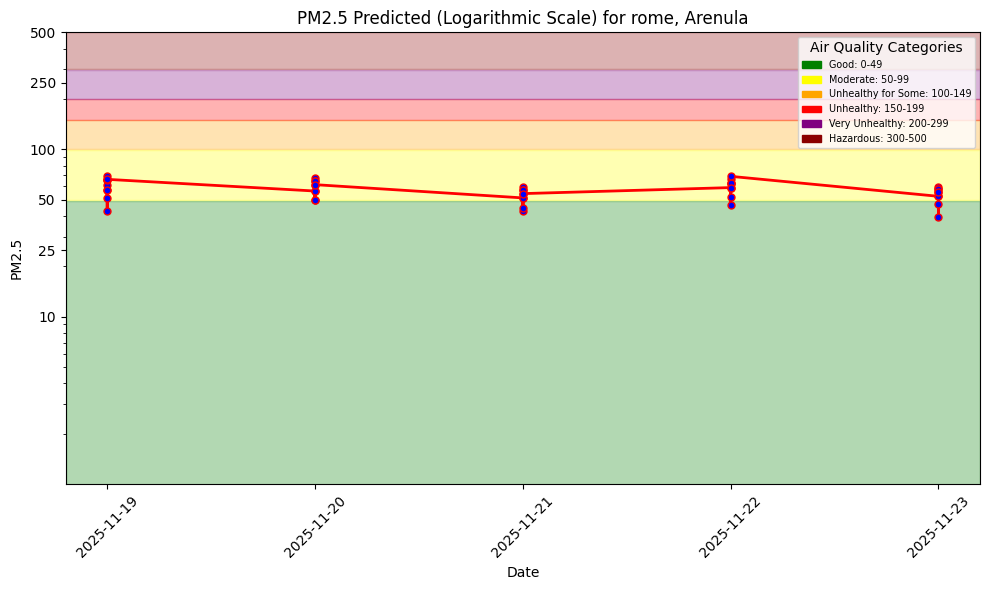

In [13]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

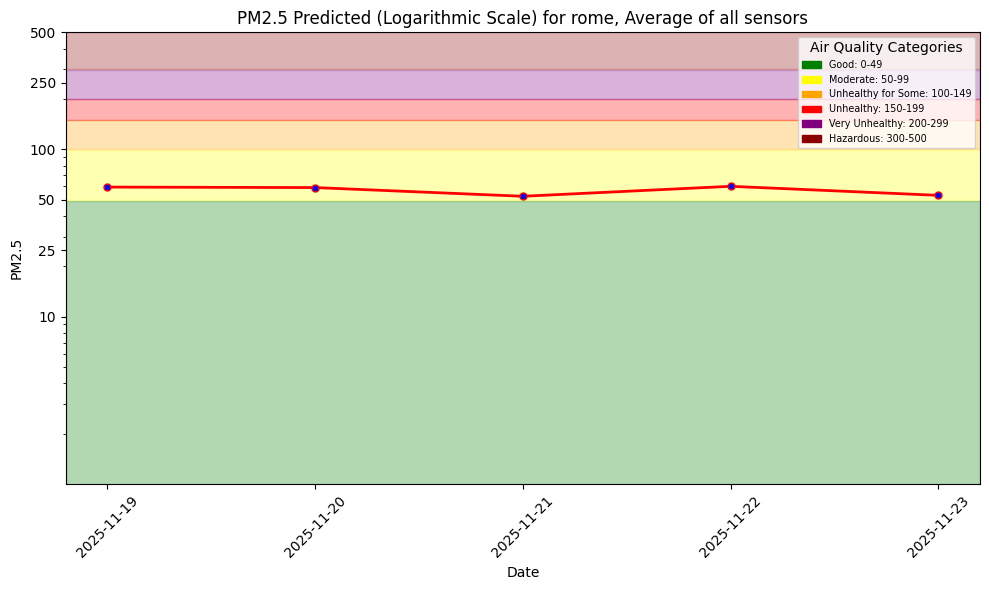

In [14]:
# Average of all sensors
avg_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_average.png"

# Average predictions across all sensors for each date
avg = batch_data.groupby('date').agg({
    'predicted_pm25': 'mean'
}).reset_index()

plt = util.plot_air_quality_forecast(city, 'Average of all sensors', avg, avg_file_path)
plt.show()

In [15]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=2,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [16]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |█| Rows 45/45 | Elapsed Time: 00:02 | Remaining Ti


Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1299605/jobs/named/aq_predictions_2_offline_fg_materialization/executions
2025-11-18 09:52:16,483 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 09:52:20,474 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 09:53:58,639 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 09:53:59,567 INFO: Waiting for log aggregation to finish.
2025-11-18 09:54:10,255 INFO: Execution finished successfully.


(Job('aq_predictions_2_offline_fg_materialization', 'SPARK'), None)

In [17]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitor_fg
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.74s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,relative_humidity_2m_mean,surface_pressure_mean,city,pm25_lagged1,pm25_lagged2,pm25_lagged3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-20 00:00:00+00:00,13.750000,0.7,7.952660,174.805664,90.000000,1004.885132,rome,65.0,68.0,68.0,63.441925,rome,italy,1
1,2025-11-18 00:00:00+00:00,15.450000,0.3,3.396233,32.005356,83.000000,1007.696655,rome,55.0,68.0,68.0,51.643002,rome,italy,1
2,2025-11-20 00:00:00+00:00,13.600000,0.7,7.280550,188.530685,92.000000,1005.481018,rome,42.0,42.0,42.0,49.894447,Guido,italy,1
3,2025-11-20 00:00:00+00:00,13.600000,0.7,7.280550,188.530685,92.000000,1005.481018,rome,63.0,63.0,63.0,67.610268,Cavaliere,italy,1
4,2025-11-20 00:00:00+00:00,13.600000,0.7,7.280550,188.530685,92.000000,1005.481018,rome,59.0,59.0,59.0,61.413593,Cipro,italy,1
5,2025-11-20 00:00:00+00:00,13.600000,0.7,7.280550,188.530685,92.000000,1005.481018,rome,61.0,61.0,61.0,64.299736,Francia,italy,1
6,2025-11-20 00:00:00+00:00,13.600000,0.7,7.280550,188.530685,92.000000,1005.481018,rome,50.0,50.0,50.0,50.086575,Malagrotta,italy,1
7,2025-11-20 00:00:00+00:00,13.600000,0.7,7.280550,188.530685,92.000000,1005.481018,rome,57.0,57.0,57.0,61.510868,Villa ada,italy,1
8,2025-11-20 00:00:00+00:00,13.600000,0.7,7.280550,188.530685,92.000000,1005.481018,rome,55.0,55.0,55.0,56.335941,Guidonia,italy,1
9,2025-11-20 00:00:00+00:00,13.600000,0.7,7.280550,188.530685,92.000000,1005.481018,rome,61.0,61.0,61.0,64.299736,Cinecitta',italy,1


In [18]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.82s) 


,date,pm25,country,city,street,url
0,2018-07-30 00:00:00+00:00,63.0,italy,rome,rome,https://api.waqi.info/feed/@9352
1,2018-08-19 00:00:00+00:00,30.0,italy,rome,rome,https://api.waqi.info/feed/@9352
2,2021-07-28 00:00:00+00:00,46.0,italy,rome,rome,https://api.waqi.info/feed/@9352
3,2024-06-11 00:00:00+00:00,34.0,italy,rome,rome,https://api.waqi.info/feed/@9352
4,2024-03-30 00:00:00+00:00,63.0,italy,rome,rome,https://api.waqi.info/feed/@9352
...,...,...,...,...,...,...
39052,2025-11-18 00:00:00+00:00,55.0,italy,rome,Arenula,https://api.waqi.info/feed/@9352
39053,2025-11-18 00:00:00+00:00,55.0,italy,rome,Guidonia,https://api.waqi.info/feed/@9344
39054,2025-11-18 00:00:00+00:00,63.0,italy,rome,Cavaliere,https://api.waqi.info/feed/@9347
39055,2025-11-18 00:00:00+00:00,57.0,italy,rome,Villa ada,https://api.waqi.info/feed/@9345


In [19]:
outcome_df = air_quality_df[['date', 'pm25']]
outcome_df
preds_df =  monitoring_df[['date', 'predicted_pm25']]
preds_df

outcome_df['date'] = pd.to_datetime(outcome_df['date'])
preds_df['date'] = pd.to_datetime(preds_df['date'])

hindcast_df = pd.merge(preds_df, outcome_df, on="date")

hindcast_df['date'] = pd.to_datetime(hindcast_df['date'])

hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

2025-11-18 09:54:18,914 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-11-18 09:54:18,915 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,predicted_pm25,pm25
100,2025-11-14 00:00:00+00:00,67.133499,68.0
193,2025-11-14 00:00:00+00:00,66.086021,70.0
159,2025-11-14 00:00:00+00:00,62.952793,63.0
83,2025-11-14 00:00:00+00:00,62.578178,68.0
82,2025-11-14 00:00:00+00:00,62.578178,57.0
...,...,...,...
4,2025-11-18 00:00:00+00:00,51.643002,55.0
3,2025-11-18 00:00:00+00:00,51.643002,50.0
2,2025-11-18 00:00:00+00:00,51.643002,61.0
1,2025-11-18 00:00:00+00:00,51.643002,61.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

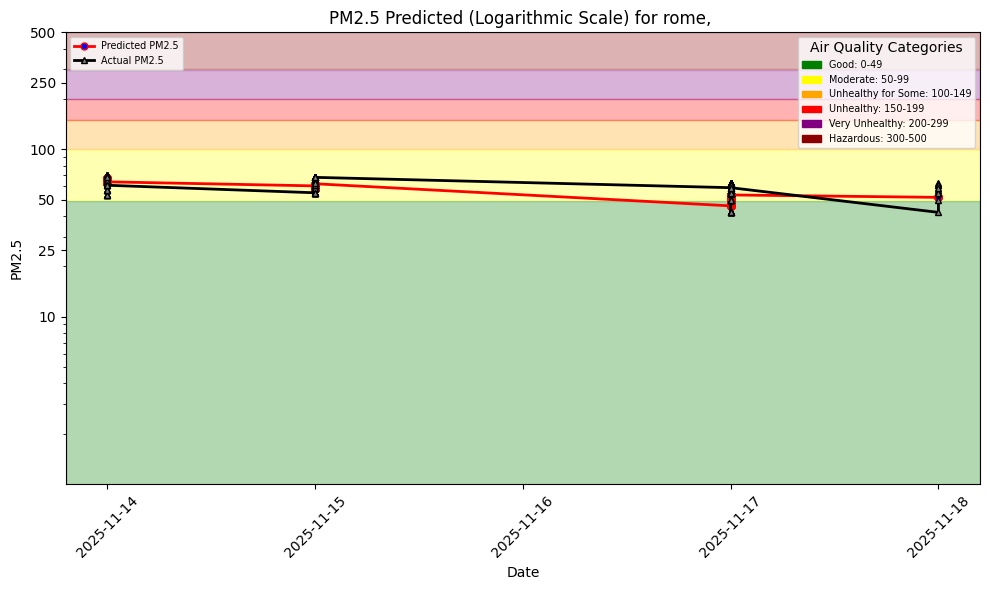

In [20]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, '', hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [21]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/alessandrobertelli/Desktop/University/KTH/mlfs-book/docs/air-quality/assets/img/pm25_forecast…

Uploading /Users/alessandrobertelli/Desktop/University/KTH/mlfs-book/docs/air-quality/assets/img/pm25_hindcast…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1299605/settings/fb/path/Resources/airquality


---